# FRAUD TRANSACTION DETECTION

### Attained 96% acuracy and 98% AUC and 97% Recall. So, the model is identifying the frauds 97% times and hence this is the best approach. Comparison with other approaches is also shown in the notebook.

### ACCESS THIS GITHUB LINK TO DOWNLOAD RESOURCES - https://github.com/KroNicalKODER/Transaction-Fraud-Assignment

In [ ]:
file_path = "/kaggle/input/fraud-transactions/Fraud (1).csv"

In [ ]:
# importing Libraries

import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

In [ ]:
## READING THE CSV FILE
df = pd.read_csv(file_path)

In [ ]:
# Total number of rows
total_rows = len(df)

# Count of rows where isFraud is 1
fraud_rows = df[df['isFraud'] == 1].shape[0]

# Count of rows where isFraud is 0
non_fraud_rows = df[df['isFraud'] == 0].shape[0]

print(f"Total rows: {total_rows}")
print(f"Fraudulent transactions: {fraud_rows}")
print(f"Non-fraudulent transactions: {non_fraud_rows}")

Total rows: 6362620
Fraudulent transactions: 8213
Non-fraudulent transactions: 6354407


In [ ]:
# Check if any merchant transactions are fraudulent
merchant_mask = df['nameDest'].str.startswith('M')
merchant_fraud_count = df[merchant_mask & (df['isFraud'] == 1)].shape[0]
merchant_total_count = df[merchant_mask].shape[0]

print(f"Total merchant transactions: {merchant_total_count}")
print(f"Fraudulent merchant transactions: {merchant_fraud_count}")

Total merchant transactions: 2151495
Fraudulent merchant transactions: 0


### REMOVING SOME MERCHANT TRANSACTIONS
#### Since all merchant transactions are non-fraudulent then its better to remove some rows to create the data balance.

In [ ]:
# Remove rows where 'nameDest' starts with 'M' (Merchant Transactions)
df_no_merchant = df[~df['nameDest'].str.startswith('M')]

df_no_merchant = df_no_merchant[~df_no_merchant['nameOrig'].str.startswith('M')]

# Verify changes
print(f"Remaining rows after removal: {df_no_merchant.shape[0]}")
print(f"Fraudulent transactions: {df_no_merchant['isFraud'].sum()}")
print(f"Non-fraudulent transactions: {df_no_merchant.shape[0] - df['isFraud'].sum()}")


Remaining rows after removal: 4211125
Fraudulent transactions: 8213
Non-fraudulent transactions: 4202912


In [ ]:
# DROPPING THE ROWS WHICH HAVE 0 ON ALL THE COLUMNS AS THEY DONT PROVIDE ANY SPECIFIC TRANSACTIONS AND ARE DATA NOISE

# Finding rows where all specified columns are 0
zero_rows = df_no_merchant[(df_no_merchant['oldbalanceOrg'] == 0) &
                           (df_no_merchant['newbalanceOrig'] == 0) &
                           (df_no_merchant['oldbalanceDest'] == 0) &
                           (df_no_merchant['newbalanceDest'] == 0) ]

# Count the number of such rows
num_zero_rows = zero_rows.shape[0]
print("Number of rows where all specified columns are 0:", num_zero_rows)

# Dropping these rows
df_no_merchant = df_no_merchant.drop(zero_rows.index)

# Reset index after dropping (optional)
df_no_merchant.reset_index(drop=True, inplace=True)

print("Rows after dropping:", df_no_merchant.shape[0])


Number of rows where all specified columns are 0: 30
Rows after dropping: 4211095


In [ ]:
df = df_no_merchant

4211095

## FEATURE ENGINEERING
#### Why These features
##### amount_to_oldbalanceOrig_ratio - High ratio (close to 1 or more) might indicate suspicious behavior—like draining the entire account.
##### amount_to_oldbalanceDest_ratio - A high ratio may mean sudden large inflow into an account with little/no previous activity, often seen in money mule or shell accounts.
##### orig_balance_change - In fraud cases, sometimes the balance does not actually change (simulated transactions)
##### dest_balance_change - If there’s no increase despite a transfer, it might suggest a suspicious transaction (e.g., failed fraud).
##### is_large_transfer - Flags high-value transfers, which are more likely to be fraudulent.
##### is_balance_zero_after_transaction - If someone’s balance becomes exactly zero, it might indicate suspicious behavior like account draining.
##### hour_of_day - Helps identify if transactions are happening at unusual hours (e.g., 2 AM), which could indicate fraud.
##### Flags newly active accounts receiving funds.

In [ ]:
## FEATURE ENGINEERING

# Assuming df is your dataset
df['amount_to_oldbalanceOrig_ratio'] = df['amount'] / (df['oldbalanceOrg'] + 1)
df['amount_to_oldbalanceDest_ratio'] = df['amount'] / (df['oldbalanceDest'] + 1)

df['orig_balance_change'] = df['newbalanceOrig'] - df['oldbalanceOrg']
df['dest_balance_change'] = df['newbalanceDest'] - df['oldbalanceDest']

df['is_large_transfer'] = ((df['amount'] > 200000) & (df['type'] == 'TRANSFER')).astype(int)
df['is_balance_zero_after_transaction'] = (df['newbalanceOrig'] == 0).astype(int)

df['hour_of_day'] = df['step'] % 24

df['is_dest_new_account'] = ((df['oldbalanceDest'] == 0) & (df['newbalanceDest'] > 0)).astype(int)

# Display a few rows to verify the new features
df.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,amount_to_oldbalanceOrig_ratio,amount_to_oldbalanceDest_ratio,orig_balance_change,dest_balance_change,is_large_transfer,is_balance_zero_after_transaction,hour_of_day,is_dest_new_account
0,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.00,1,0,0.994505,181.000000,-181.00,0.00,0,1,1,0
1,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.00,1,0,0.994505,0.008545,-181.00,-21182.00,0,1,1,0
2,1,DEBIT,5337.77,C712410124,41720.0,36382.23,C195600860,41898.0,40348.79,0,0,0.127940,0.127396,-5337.77,-1549.21,0,0,1,0
3,1,DEBIT,9644.94,C1900366749,4465.0,0.00,C997608398,10845.0,157982.12,0,0,2.159637,0.889262,-4465.00,147137.12,0,1,1,0
4,1,CASH_OUT,229133.94,C905080434,15325.0,0.00,C476402209,5083.0,51513.44,0,0,14.950668,45.069618,-15325.00,46430.44,0,1,1,0


## DATA VISUALIZATION

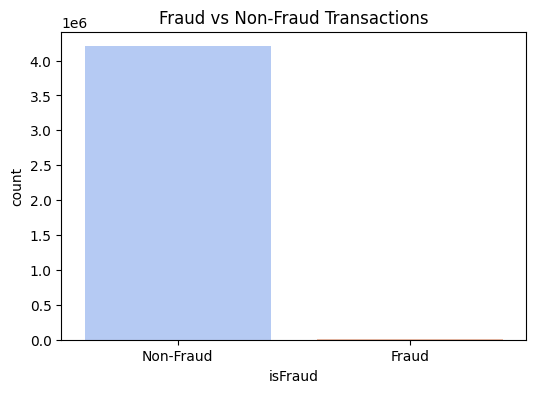

In [ ]:
## VISUALIZATION
import matplotlib.pyplot as plt
import seaborn as sns

# Fraud vs. Non-Fraud Count
plt.figure(figsize=(6, 4))
sns.countplot(x='isFraud', data=df, palette='coolwarm')
plt.title("Fraud vs Non-Fraud Transactions")
plt.xticks(ticks=[0, 1], labels=['Non-Fraud', 'Fraud'])
plt.show()

## THIS SHOWS DATA IS HIGHLY IMBALANCE AND NEED DOWNSAMPLING OF CLASS 0.

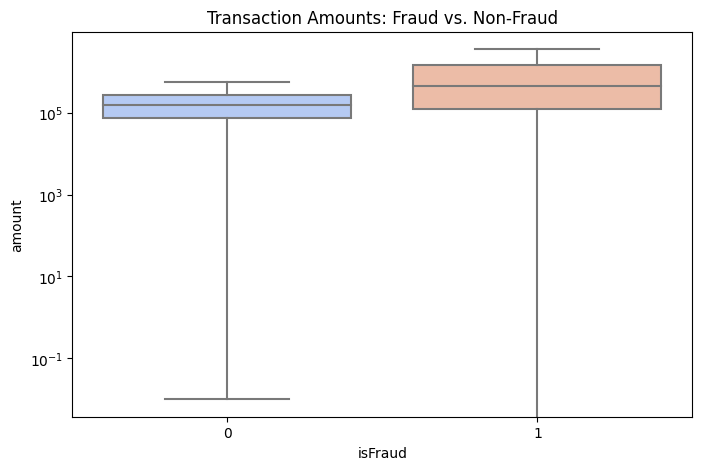

In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='isFraud', y='amount', data=df, palette='coolwarm', showfliers=False)
plt.yscale("log")  # Log scale for better visualization
plt.title("Transaction Amounts: Fraud vs. Non-Fraud")
plt.show()

## WE CAN AND WILL CLEAN THE DATA OF NON-FRAUDULENT TRANSACTIONS with AMOUNT LESS THE 25 percentile in FRAUD cases.

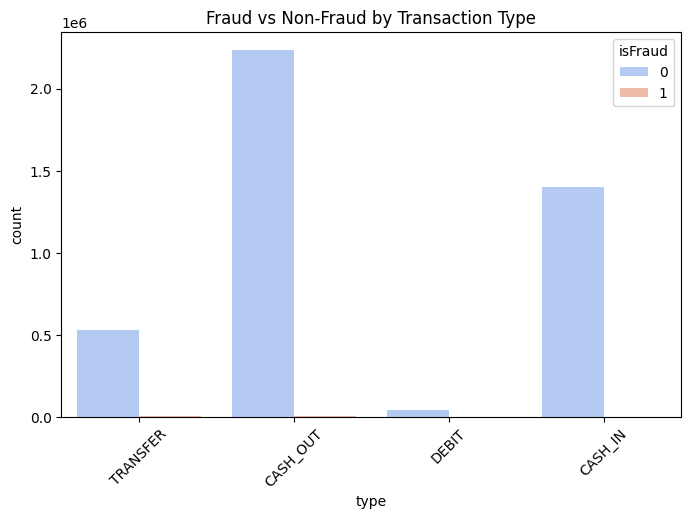

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(x='type', hue='isFraud', data=df, palette='coolwarm')
plt.title("Fraud vs Non-Fraud by Transaction Type")
plt.xticks(rotation=45)
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

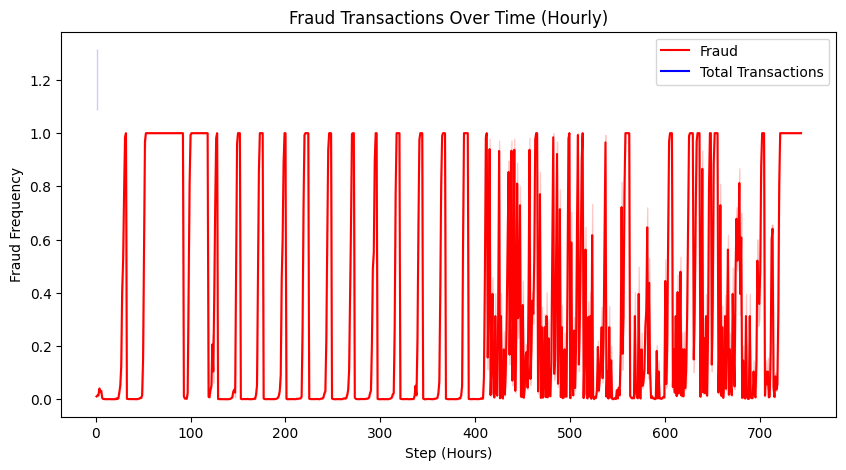

In [ ]:
plt.figure(figsize=(10, 5))
sns.lineplot(x=df['step'], y=df['isFraud'].rolling(window=24).mean(), label="Fraud", color="red")
sns.lineplot(x=df['step'], y=df['isFraud'].rolling(window=24).count()/df['step'].value_counts().sort_index(), label="Total Transactions", color="blue")
plt.title("Fraud Transactions Over Time (Hourly)")
plt.xlabel("Step (Hours)")
plt.ylabel("Fraud Frequency")
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


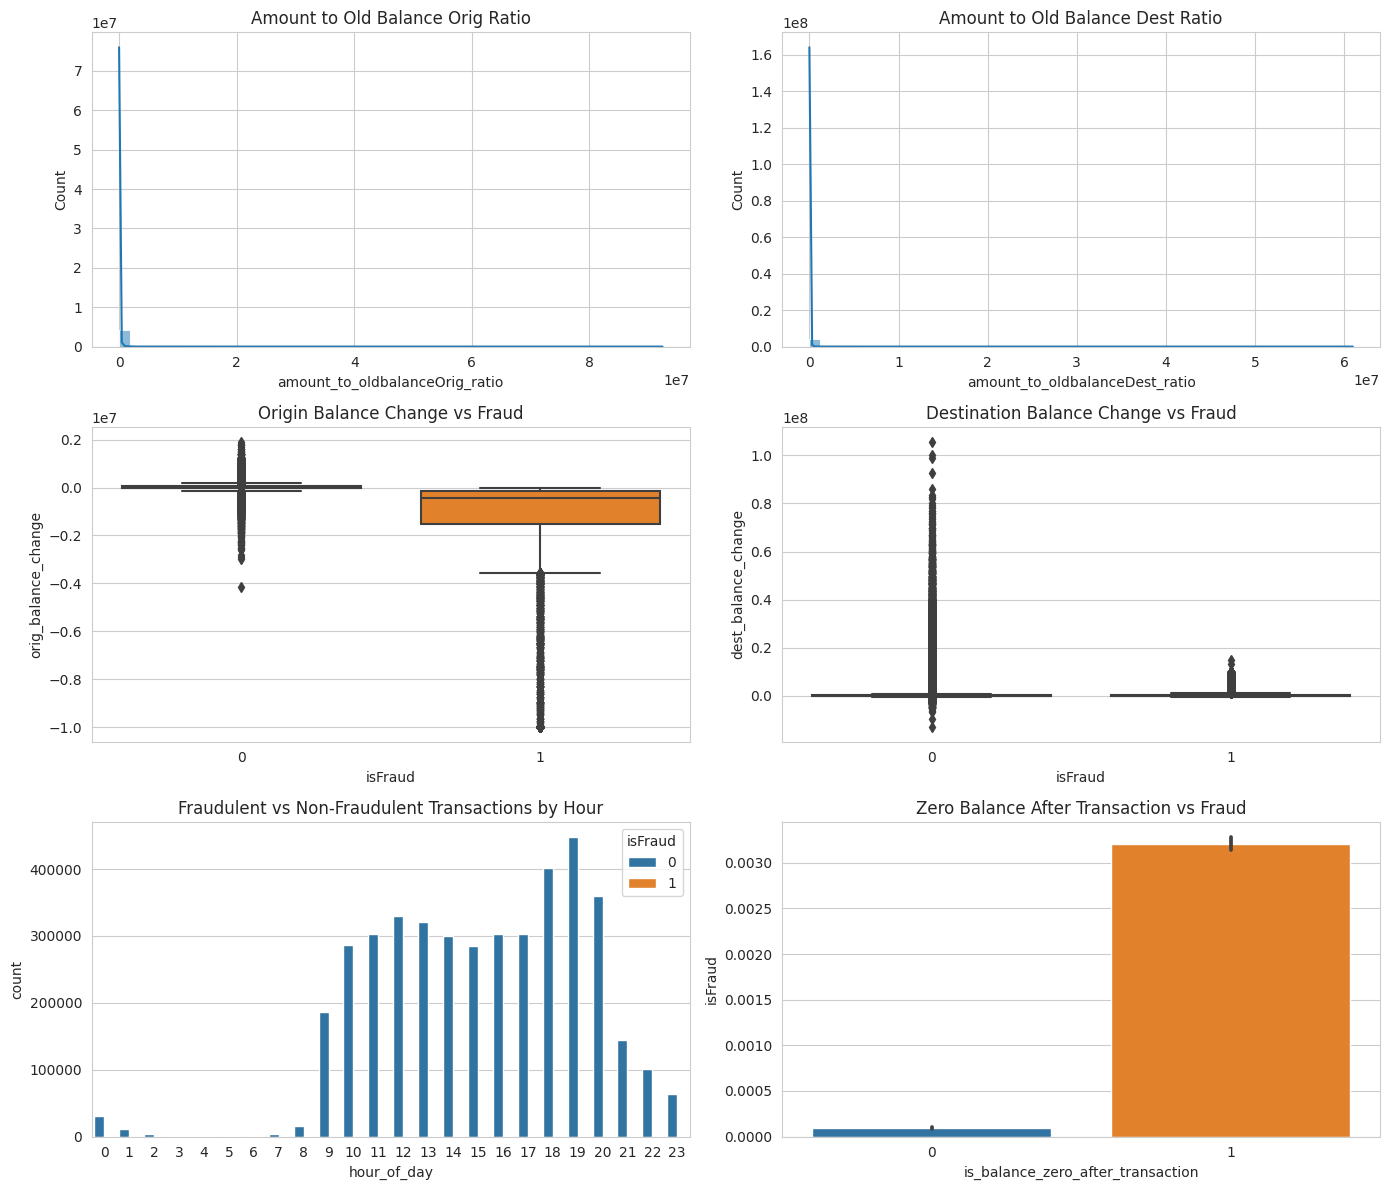

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_style("whitegrid")

# Create subplots for visualization
fig, axes = plt.subplots(3, 2, figsize=(14, 12))

# Distribution of amount to old balance origin ratio
sns.histplot(df['amount_to_oldbalanceOrig_ratio'], bins=50, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Amount to Old Balance Orig Ratio')

# Distribution of amount to old balance destination ratio
sns.histplot(df['amount_to_oldbalanceDest_ratio'], bins=50, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Amount to Old Balance Dest Ratio')

# Boxplot of origin balance change vs Fraud
sns.boxplot(x=df['isFraud'], y=df['orig_balance_change'], ax=axes[1, 0])
axes[1, 0].set_title('Origin Balance Change vs Fraud')

# Boxplot of destination balance change vs Fraud
sns.boxplot(x=df['isFraud'], y=df['dest_balance_change'], ax=axes[1, 1])
axes[1, 1].set_title('Destination Balance Change vs Fraud')

# Count plot of transactions happening per hour
sns.countplot(x=df['hour_of_day'], hue=df['isFraud'], ax=axes[2, 0])
axes[2, 0].set_title('Fraudulent vs Non-Fraudulent Transactions by Hour')

# Bar plot for is_balance_zero_after_transaction
sns.barplot(x=df['is_balance_zero_after_transaction'], y=df['isFraud'], ax=axes[2, 1])
axes[2, 1].set_title('Zero Balance After Transaction vs Fraud')

plt.tight_layout()
plt.show()

## THESE GRAPHS ARE REALLY HELPFUL FOR UNDERSTANDING THE DATA AND MAKING DATA CLEANING DECISIONS. THE GRAPH HOURS vs FRAUD/NON-FRAUD helped to clear a lot of data.

## DATA CLEANING BASED ON VISUALIZATION

In [ ]:
## DROPPING from Non-Frraudulent Transactions with amount lower than 30 percentile in Fraudulent Transactions See the graph above.

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Compute 30 percentile
q3_fraud = np.percentile(df[df['isFraud'] == 1]['amount'], 30)

# Filter non-fraudulent transactions below
low_value_non_fraud = df[(df['isFraud'] == 0) & (df['amount'] < q3_fraud)]

# Count of records before deletion
print(f"Total non-fraudulent transactions below Q3: {low_value_non_fraud.shape[0]}")

delete_prob = 0.8  # 80% chance of deletion

# Randomly select rows to drop
drop_indices = low_value_non_fraud.sample(frac=delete_prob, random_state=42).index


Total non-fraudulent transactions below Q3: 2193130


Total records after downsampling: 2456591


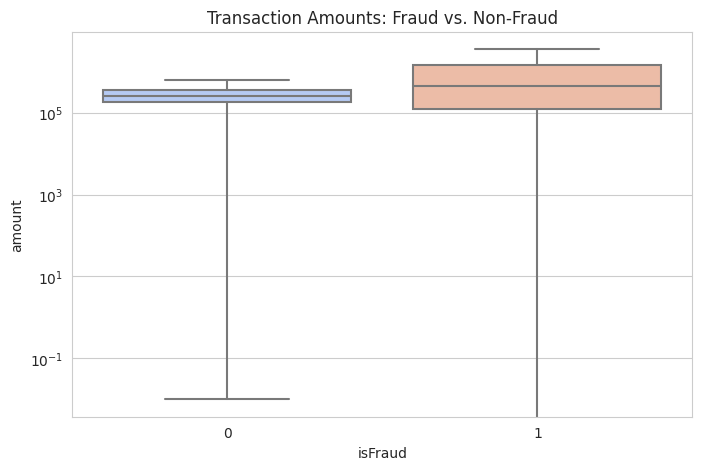

In [ ]:
# Drop selected rows
df_filtered = df.drop(index=drop_indices)

# Print new shape after dropping
print(f"Total records after downsampling: {df_filtered.shape[0]}")

# Plot after dropping
plt.figure(figsize=(8, 5))
sns.boxplot(x='isFraud', y='amount', data=df_filtered, palette='coolwarm', showfliers=False)
plt.yscale("log")  # Log scale for better visualization
plt.title("Transaction Amounts: Fraud vs. Non-Fraud")
plt.show()

In [ ]:
# Filter non-fraudulent transactions with amount less than 15000
low_15000_non_fraud = df_filtered[(df_filtered['isFraud'] == 0) & (df_filtered['amount'] < 15000)]

# Display how many such records exist
print("Number of non-fraudulent transactions below 15,000:", low_15000_non_fraud.shape[0])

# Drop all of them from the dataframe
df_filtered = df_filtered.drop(index=low_15000_non_fraud.index)

# Print the updated shape
print("Shape of the remaining df: ", df_filtered.shape[0])

Number of non-fraudulent transactions below 15,000: 46361
Shape of the remaining df:  2410230


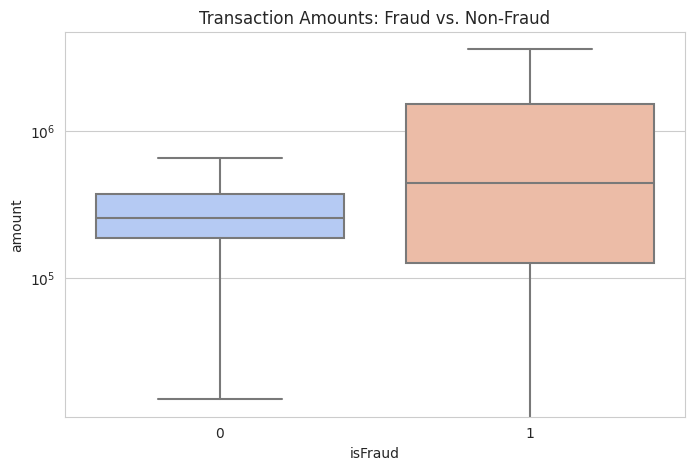

In [ ]:
# Plot after dropping
plt.figure(figsize=(8, 5))
sns.boxplot(x='isFraud', y='amount', data=df_filtered, palette='coolwarm', showfliers=False)
plt.yscale("log")  # Log scale for better visualization
plt.title("Transaction Amounts: Fraud vs. Non-Fraud")
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


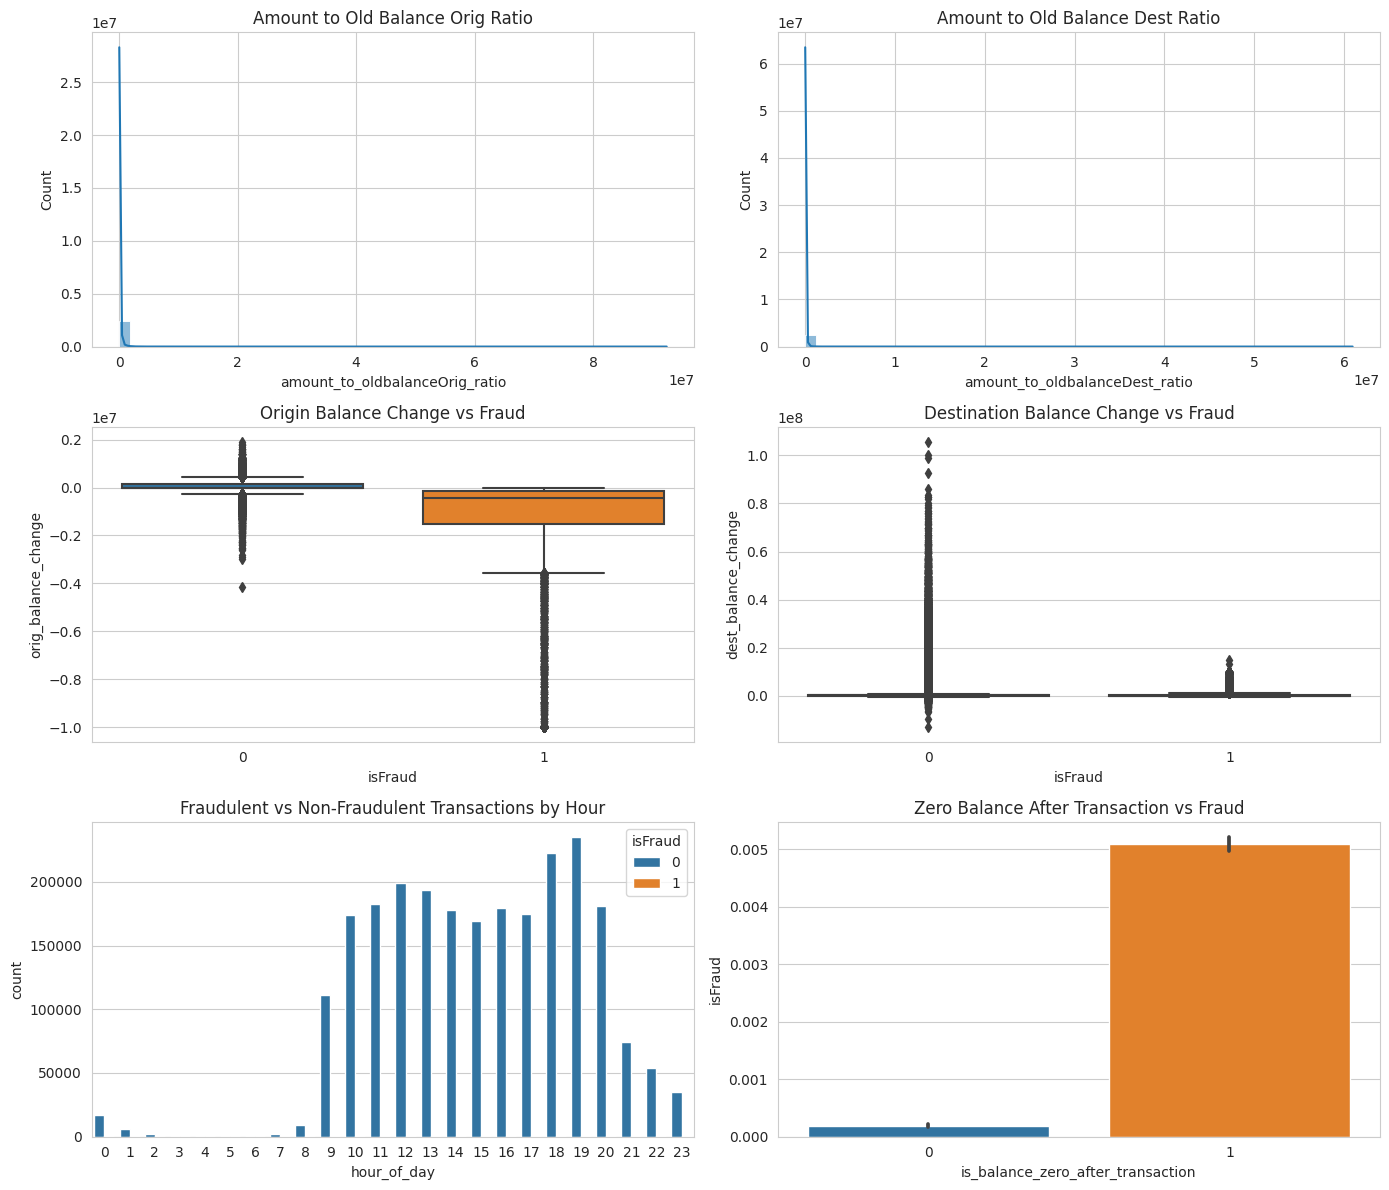

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_style("whitegrid")

# Create subplots for visualization
fig, axes = plt.subplots(3, 2, figsize=(14, 12))

# Distribution of amount to old balance origin ratio
sns.histplot(df_filtered['amount_to_oldbalanceOrig_ratio'], bins=50, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Amount to Old Balance Orig Ratio')

# Distribution of amount to old balance destination ratio
sns.histplot(df_filtered['amount_to_oldbalanceDest_ratio'], bins=50, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Amount to Old Balance Dest Ratio')

# Boxplot of origin balance change vs Fraud
sns.boxplot(x=df_filtered['isFraud'], y=df_filtered['orig_balance_change'], ax=axes[1, 0])
axes[1, 0].set_title('Origin Balance Change vs Fraud')

# Boxplot of destination balance change vs Fraud
sns.boxplot(x=df_filtered['isFraud'], y=df_filtered['dest_balance_change'], ax=axes[1, 1])
axes[1, 1].set_title('Destination Balance Change vs Fraud')

# Count plot of transactions happening per hour
sns.countplot(x=df_filtered['hour_of_day'], hue=df_filtered['isFraud'], ax=axes[2, 0])
axes[2, 0].set_title('Fraudulent vs Non-Fraudulent Transactions by Hour')

# Bar plot for is_balance_zero_after_transaction
sns.barplot(x=df_filtered['is_balance_zero_after_transaction'], y=df_filtered['isFraud'], ax=axes[2, 1])
axes[2, 1].set_title('Zero Balance After Transaction vs Fraud')

plt.tight_layout()
plt.show()


In [ ]:
## KEEP ONLY TWICE NON-FRAUD RECORDS ie 2:1 ratio. See count vs hour of the day graph....

import pandas as pd
import numpy as np

# Step 1: Count fraud and non-fraud transactions per hour
non_fraud_counts_per_hour = df_filtered[df_filtered['isFraud'] == 0]['hour_of_day'].value_counts()
fraud_counts_per_hour = df_filtered[df_filtered['isFraud'] == 1]['hour_of_day'].value_counts()

# Step 2: Balance each hour → keep non-fraud = 2 × fraud
for hour in non_fraud_counts_per_hour.index:
    fraud_count = fraud_counts_per_hour.get(hour, 0)
    non_fraud_indices = df_filtered[(df_filtered['isFraud'] == 0) & (df_filtered['hour_of_day'] == hour)].index

    target_non_fraud = 2 * fraud_count  # goal is to keep only 2x fraud count

    if len(non_fraud_indices) > target_non_fraud:
        drop_indices = np.random.choice(non_fraud_indices, size=len(non_fraud_indices) - target_non_fraud, replace=False)
        df_filtered = df_filtered.drop(index=drop_indices)

# Final counts
print("Shape after all drops:", df_filtered.shape)
print("Fraudulent count:", df_filtered[df_filtered['isFraud'] == 1].shape[0])
print("Non-Fraudulent count:", df_filtered[df_filtered['isFraud'] == 0].shape[0])


Shape after all drops: (23736, 19)
Fraudulent count: 8207
Non-Fraudulent count: 15529


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


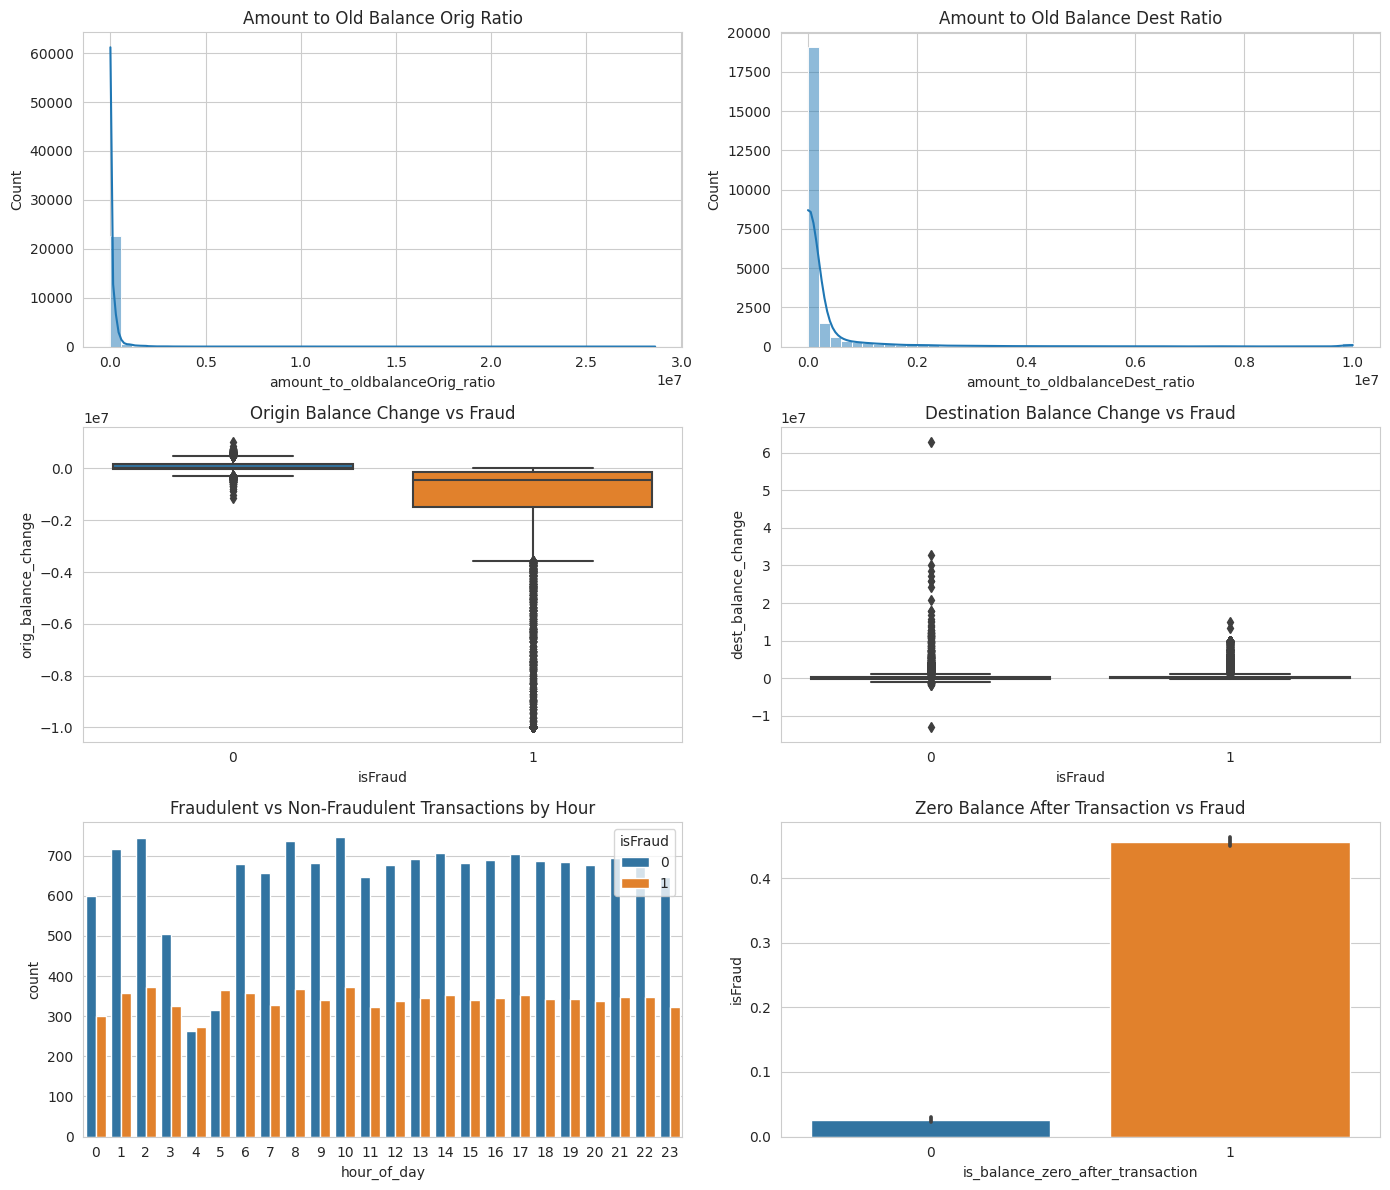

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_style("whitegrid")

# Create subplots for visualization
fig, axes = plt.subplots(3, 2, figsize=(14, 12))

# Distribution of amount to old balance origin ratio
sns.histplot(df_filtered['amount_to_oldbalanceOrig_ratio'], bins=50, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Amount to Old Balance Orig Ratio')

# Distribution of amount to old balance destination ratio
sns.histplot(df_filtered['amount_to_oldbalanceDest_ratio'], bins=50, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Amount to Old Balance Dest Ratio')

# Boxplot of origin balance change vs Fraud
sns.boxplot(x=df_filtered['isFraud'], y=df_filtered['orig_balance_change'], ax=axes[1, 0])
axes[1, 0].set_title('Origin Balance Change vs Fraud')

# Boxplot of destination balance change vs Fraud
sns.boxplot(x=df_filtered['isFraud'], y=df_filtered['dest_balance_change'], ax=axes[1, 1])
axes[1, 1].set_title('Destination Balance Change vs Fraud')

# Count plot of transactions happening per hour
sns.countplot(x=df_filtered['hour_of_day'], hue=df_filtered['isFraud'], ax=axes[2, 0])
axes[2, 0].set_title('Fraudulent vs Non-Fraudulent Transactions by Hour')

# Bar plot for is_balance_zero_after_transaction
sns.barplot(x=df_filtered['is_balance_zero_after_transaction'], y=df_filtered['isFraud'], ax=axes[2, 1])
axes[2, 1].set_title('Zero Balance After Transaction vs Fraud')

plt.tight_layout()
plt.show()


#### NOW THE DATA APPEARS TO BE MORE BALANCED AND READY TO TRAIN.
#### WE are not required to do data imputations and other cleaning stuff as this could introduce bias in the data and hence could make the model overfit.

In [ ]:
# Total number of rows
total_rows = len(df_filtered)

# Count of rows where isFraud is 1
fraud_rows = df_filtered[df_filtered['isFraud'] == 1].shape[0]

# Count of rows where isFraud is 0
non_fraud_rows = df_filtered[df_filtered['isFraud'] == 0].shape[0]

print(f"Total rows: {total_rows}")
print(f"Fraudulent transactions: {fraud_rows}")
print(f"Non-fraudulent transactions: {non_fraud_rows}")

Total rows: 23736
Fraudulent transactions: 8207
Non-fraudulent transactions: 15529


In [ ]:
## save the dataset as CSV
df_filtered.to_pickle("/kaggle/working/df_filtered.pkl")

# TRAINING USING PYCARET

In [1]:
!pip install pycaret

In [2]:
import pandas as pd
df_filtered = pd.read_pickle("/content/df_filtered.pkl")
df_filtered.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,amount_to_oldbalanceOrig_ratio,amount_to_oldbalanceDest_ratio,orig_balance_change,dest_balance_change,is_large_transfer,is_balance_zero_after_transaction,hour_of_day,is_dest_new_account
0,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.00,0.00,1,0,0.994505,181.000000,-181.00,0.00,0,1,1,0
1,1,CASH_OUT,181.00,C840083671,181.00,0.0,C38997010,21182.00,0.00,1,0,0.994505,0.008545,-181.00,-21182.00,0,1,1,0
13,1,CASH_OUT,23261.30,C2072313080,20411.53,0.0,C2001112025,25742.00,0.00,0,0,1.139560,0.903597,-20411.53,-25742.00,0,1,1,0
38,1,TRANSFER,209711.11,C1556867940,0.00,0.0,C1509514333,399214.71,2415.16,0,0,209711.110000,0.525308,0.00,-396799.55,1,1,1,0
78,1,CASH_OUT,193605.38,C2029372696,0.00,0.0,C1971489295,249452.05,0.00,0,0,193605.380000,0.776120,0.00,-249452.05,0,1,1,0


In [4]:
from pycaret.classification import *

# Setup PyCaret with automatic preprocessing and imbalance fixing
clf_setup = setup(data=df_filtered,
                  target='isFraud',
                  session_id=42,
                  fix_imbalance=True,
                  normalize=True,
                  verbose=True)


,Description,Value
0,Session id,42
1,Target,isFraud
2,Target type,Binary
3,Original data shape,"(23736, 19)"
4,Transformed data shape,"(28861, 22)"
5,Transformed train set shape,"(21740, 22)"
6,Transformed test set shape,"(7121, 22)"
7,Numeric features,15
8,Categorical features,3
9,Preprocess,True


done


In [6]:
# Compare models using F1 score to account for imbalance
best_models = compare_models(sort='F1', n_select=5, turbo=True)


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
svm,SVM - Linear Kernel,0.6274,0.8898,0.8282,0.5394,0.5901,0.3037,0.3846,0.3040
knn,K Neighbors Classifier,0.7409,0.6427,0.2571,0.9757,0.4068,0.3069,0.4192,1.2310
qda,Quadratic Discriminant Analysis,0.4387,0.4397,0.7005,0.5421,0.3608,0.0009,0.0152,0.3400
et,Extra Trees Classifier,0.7046,0.9622,0.1478,0.9888,0.2520,0.1820,0.3100,0.7210
lr,Logistic Regression,0.6925,0.8991,0.1212,0.9201,0.2139,0.1453,0.2634,0.3500
lda,Linear Discriminant Analysis,0.6526,0.5920,0.0040,0.1548,0.0078,-0.0008,-0.0033,0.3190
nb,Naive Bayes,0.6550,0.5011,0.0023,1.0000,0.0045,0.0030,0.0380,0.8640
dt,Decision Tree Classifier,0.6542,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.5740
ridge,Ridge Classifier,0.6542,0.6822,0.0000,0.0000,0.0000,0.0000,0.0000,0.2960
rf,Random Forest Classifier,0.6542,0.9917,0.0000,0.0000,0.0000,0.0000,0.0000,1.2470


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

## Which Model to train?
### From Pycaret results SVM would be the best to train as its AUC and recalls are acceptable.
### Why Not KNN with highest accuracy?
### Because these model could get higher accuracy by preciting non-fraud case which is useless.

In [8]:
from pycaret.classification import *

# Load your dataset
data = df_filtered

# Initialize setup
clf = setup(data=data, target='isFraud', session_id=42)

clf


,Description,Value
0,Session id,42
1,Target,isFraud
2,Target type,Binary
3,Original data shape,"(23736, 19)"
4,Transformed data shape,"(23736, 22)"
5,Transformed train set shape,"(16615, 22)"
6,Transformed test set shape,"(7121, 22)"
7,Numeric features,15
8,Categorical features,3
9,Preprocess,True


In [9]:
svm_model = create_model('svm')
tuned_svm = tune_model(svm_model) ## hyperparameter tuning


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9531,0.9849,0.9774,0.8963,0.9351,0.8985,0.9005
1,0.9446,0.9845,0.9600,0.8889,0.9231,0.8799,0.8815
2,0.9440,0.9846,0.9583,0.8887,0.9222,0.8786,0.8801
3,0.9597,0.9893,0.9722,0.9164,0.9435,0.9122,0.9131
4,0.9446,0.9784,0.9930,0.8665,0.9254,0.8818,0.8869
5,0.9428,0.9818,0.9634,0.8820,0.9209,0.8762,0.8783
6,0.9506,0.9812,0.9460,0.9141,0.9298,0.8917,0.8921
7,0.9500,0.9849,0.9199,0.9345,0.9271,0.8891,0.8892
8,0.9392,0.9788,0.9878,0.8578,0.9182,0.8702,0.8757


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9573,0.9796,0.9757,0.9078,0.9405,0.9072,0.9087
1,0.9513,0.9861,0.9600,0.9049,0.9316,0.8938,0.8948
2,0.9567,0.9864,0.9739,0.9076,0.9396,0.9059,0.9073
3,0.9699,0.9923,0.9774,0.9382,0.9574,0.9342,0.9346
4,0.9687,0.9880,0.9809,0.9322,0.9559,0.9317,0.9324
5,0.9651,0.9849,0.9791,0.9243,0.9509,0.9239,0.9248
6,0.9591,0.9859,0.9739,0.9134,0.9427,0.9109,0.9120
7,0.9645,0.9918,0.9756,0.9256,0.9500,0.9225,0.9232
8,0.9585,0.9833,0.9739,0.9119,0.9419,0.9096,0.9108


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [11]:
evaluate_model(tuned_svm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [12]:
final_svm = finalize_model(tuned_svm)       # Ensuring model is trained on whole

In [13]:
save_model(final_svm, 'svm_fraud_detector')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['step', 'amount', 'oldbalanceOrg',
                                              'newbalanceOrig', 'oldbalanceDest',
                                              'newbalanceDest', 'isFlaggedFraud',
                                              'amount_to_oldbalanceOrig_ratio',
                                              'amount_to_oldbalanceDest_ratio',
                                              'orig_balance_change',
                                              'dest_balance_change',
                                              'is_large_transfer',
                                              'is_balance_z...
                  SGDClassifier(alpha=0.002, average=False, class_weight=None,
                                early_stopping=False, epsilon=0.1, eta0=0.01,
                                fit_inte

In [14]:
## Load the model
from pycaret.classification import load_model

loaded_svm = load_model('svm_fraud_detector')


Transformation Pipeline and Model Successfully Loaded
